## Bike Rental Prediction: Feature Engineering

This project aims at predicting bike rental rate based on weather and holiday information. The dataset contains hourly count of public bikes rented in Seoul Bike Sharing System, along with the corresponding weather data and holidays information, and is available at: https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv

In this notebook, we perform feature engineering on the raw data

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# reading the data file from webpage
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv'
df = pd.read_csv(url, encoding='unicode_escape')

In [3]:
# see the head of dataframe
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### Exploratory Data Analysis

In [4]:
# some information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [5]:
# look for missing values
df.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

There are as many as 13 features, but no missing values. Now, we explore categorical features and dates

In [6]:
# which features are categorical
df.select_dtypes(['object']).columns

Index(['Date', 'Seasons', 'Holiday', 'Functioning Day'], dtype='object')

In [7]:
# which seasons are included
df['Seasons'].value_counts()

Summer    2208
Spring    2208
Autumn    2184
Winter    2160
Name: Seasons, dtype: int64

All 4 seasons are included

In [8]:
# exploring 'Holiday' feature
df['Holiday'].value_counts()

No Holiday    8328
Holiday        432
Name: Holiday, dtype: int64

In [9]:
# exploring 'Functioning Day' feature
df['Functioning Day'].value_counts()

Yes    8465
No      295
Name: Functioning Day, dtype: int64

'Holiday' and 'Functioning Day' are both binary features

In [10]:
# check if holiday and non-functioning day are the same
df[(df['Holiday']=='Holiday') & (df['Functioning Day']=='Yes')].shape[0]

408

'Holiday' and 'Functioning Day' are distinct features. However, functioning holidays are rather rare

In [11]:
# check which months are included
df['Date'].apply(lambda x: x.split('/')[1]).unique()

array(['12', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11'], dtype=object)

All 12 months are included

In [12]:
# check which years are included
df['Date'].apply(lambda x: x.split('/')[2]).value_counts()

2018    8016
2017     744
Name: Date, dtype: int64

Data is taken for only two consecutive year

In [13]:
# check which hours are included
df['Hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

All 24 hours are included. Next, we consider the weather features

In [14]:
# check the weather features
weather_feat = list(df.columns)[3:11]
weather_feat

['Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)']

There are 8 weather features. Let us see if they vary significantly over the time

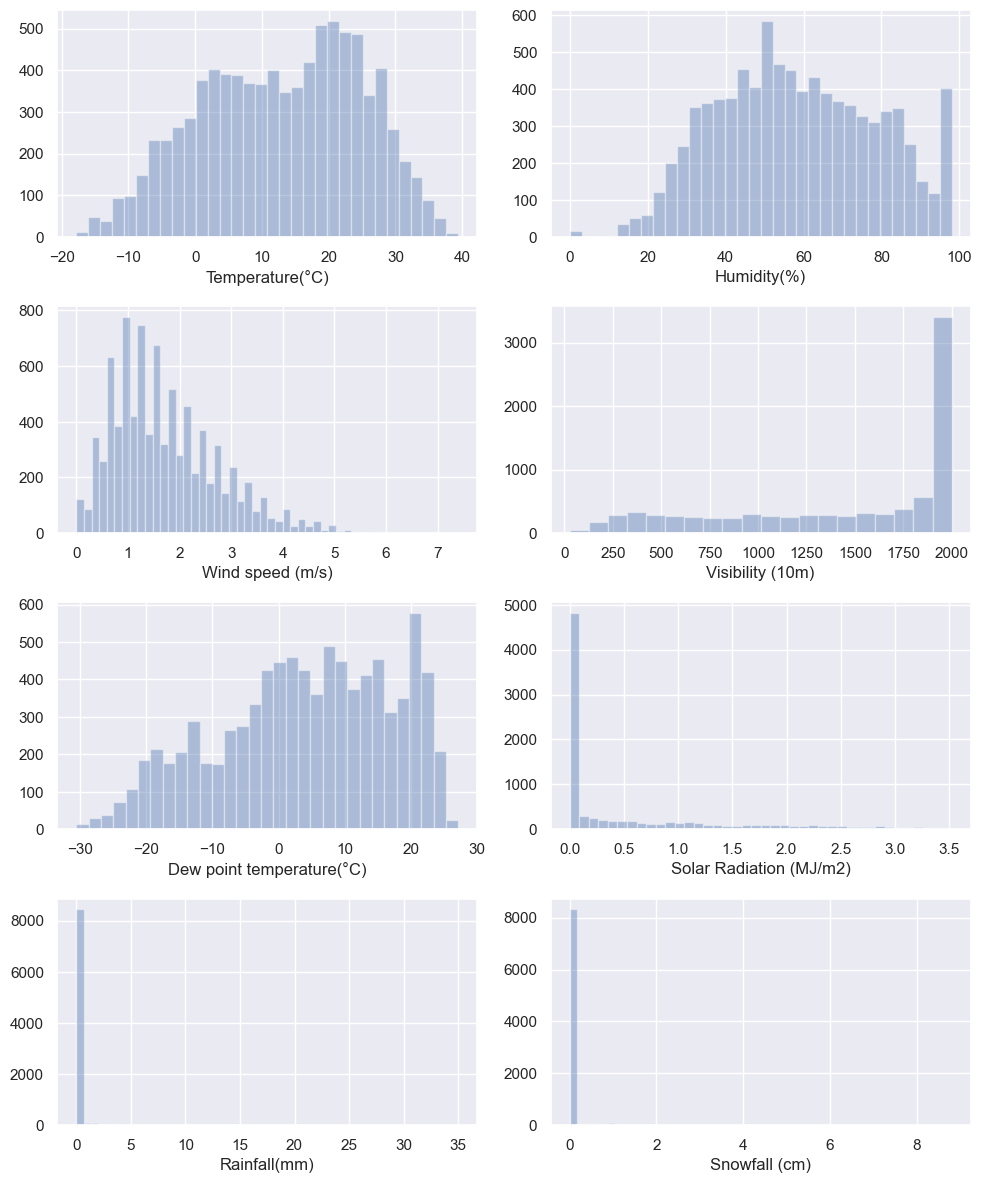

In [15]:
import matplotlib.gridspec as gridspec
sns.set() # set seaborn as default style

fig, axes = plt.subplots(4,2, figsize=(10,12),dpi=100)
gs = gridspec.GridSpec(4,2)

for i in range(8):
    sns.distplot(df[weather_feat[i]],ax=axes[int(i/2),int(i%2)],kde=False)
    
plt.tight_layout()

Solar radiation, rainfall and snowfall do not have a lot of variation (they occur very rarely). They will be more useful features if demoted to binary variables, as we see

In [16]:
# dataframe to show that the above features should be rendered binary

rare_feat = ['Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']

metrics = {'ratio_in_presence': [],
           'corr_w/_target': [],
           'corr_in_presence': [],
           'corr_binary':[]}

for feat in rare_feat:
    # instances w/ feature absent/present
    no_,yes_ = (df[df[feat]==0], df[df[feat]!=0])
    
    # rental ratio when feature is present to when absent
    ratio_= round(yes_['Rented Bike Count'].mean()/no_['Rented Bike Count'].mean(),2)
    metrics['ratio_in_presence'].append(ratio_)
    
    # feature's correlation with target
    corr_ = round(df[feat].corr(df['Rented Bike Count']),2)
    metrics['corr_w/_target'].append(corr_)
    
    # correlation with target only when feature is present
    corr_yes = round(yes_[feat].corr(yes_['Rented Bike Count']),2)
    metrics['corr_in_presence'].append(corr_yes)
    
    # correlation with target with binary feature
    corr_bin = round(df[feat].map(lambda x: 0 if x==0 else 1).corr(df['Rented Bike Count']),2)
    metrics['corr_binary'].append(corr_bin)

# creating the dataframe
df_metric = pd.DataFrame(index=rare_feat, data=metrics, columns=metrics.keys())

In [17]:
df_metric

,ratio_in_presence,corr_w/_target,corr_in_presence,corr_binary
Solar Radiation (MJ/m2),1.88,0.26,0.08,0.33
Rainfall(mm),0.22,-0.12,-0.15,-0.21
Snowfall (cm),0.25,-0.14,-0.09,-0.19


When the rare features are treated as binary, correlation with target becomes larger

### Feature Engineering/Selection

If months are included, it is redundant to include seasons. We inlcude month and exclude season

In [18]:
# include month column
df['Month'] = df['Date'].apply(lambda x: int(x.split('/')[1]))

# exclude season column
df = df.drop('Seasons', axis=1)

We include the year column, and drop the date column. The dates of the month are unimportant as holidays are separately taken into account.

In [19]:
# include year column
df['Year'] = df['Date'].apply(lambda x: x.split('/')[2])

# convert year to binary values
df['Year'] = df['Year'].map({'2017':0, '2018':1})

# exclude date column
df = df.drop('Date', axis=1)

Finally, we deal with 'Holiday' and 'Functioning Day'

In [20]:
# encoding holiday data
df['No Holiday'] = pd.get_dummies(df['Holiday'], drop_first=True)
df = df.drop('Holiday',axis=1)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Month,Year,No Holiday
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes,12,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes,12,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes,12,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes,12,0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes,12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Yes,11,1,1
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Yes,11,1,1
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Yes,11,1,1
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Yes,11,1,1


In [21]:
# encoding functioning day data
df['Funct_Day'] = pd.get_dummies(df['Functioning Day'], drop_first=True)
df = df.drop('Functioning Day',axis=1)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Month,Year,No Holiday,Funct_Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,No Holiday,12,0,1,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,No Holiday,12,0,1,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,No Holiday,12,0,1,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,No Holiday,12,0,1,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,No Holiday,12,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,No Holiday,11,1,1,1
8756,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,No Holiday,11,1,1,1
8757,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,No Holiday,11,1,1,1
8758,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,No Holiday,11,1,1,1


Inclusion of rare weather features as binary 

In [22]:
rare_feat = ['Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']
for feat in rare_feat:
    df[feat] = df[feat].map(lambda x: 0 if x==0 else 1)

In [23]:
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Month,Year,No Holiday,Funct_Day
0,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,No Holiday,Yes,12,0,1,1
1,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,No Holiday,Yes,12,0,1,1
2,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,No Holiday,Yes,12,0,1,1
3,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,No Holiday,Yes,12,0,1,1
4,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,No Holiday,Yes,12,0,1,1


Now we save the pandas dataframe for training the model and testing

In [24]:
# dataframe saved as pickle file
df.to_pickle('data_feat_eng.pkl')